In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [52]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [53]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

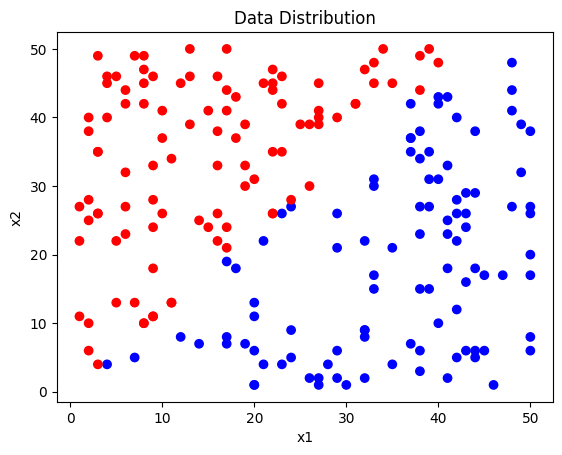

In [54]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [55]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

thresh = np.arange(0, 1, 0.001)

## Newton's Method

In [56]:
nwt = logRegAC.LogReg(max_iter=100, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=10, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  184.058
Iteration    10 | Cost:  18.423
Iteration    20 | Cost:  14.222
Iteration    30 | Cost:  12.542
Iteration    40 | Cost:  11.564
Iteration    50 | Cost:  10.900
Iteration    60 | Cost:  10.407
Iteration    70 | Cost:  10.022
Iteration    80 | Cost:  9.707
Iteration    90 | Cost:  9.443
Iteration   100 | Cost:  9.217
F1 Score:  0.9743589743589743


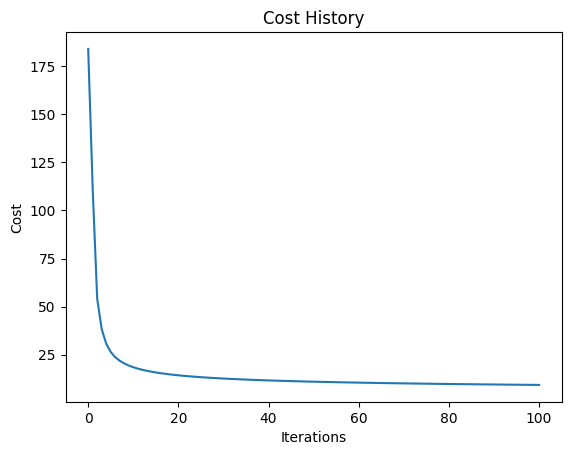

In [57]:
fig = plt.figure()
plt.plot(nwt.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/nwt_cost_hist.png')

In [58]:
nwt_trained_weights = nwt.get_params()
print(f'Trained Weights: {nwt_trained_weights}')
nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
nwt_cf_matrix = [[nwt_cf_info['tn'], nwt_cf_info['fn']], [nwt_cf_info['fp'], nwt_cf_info['tp']]]

Trained Weights: [[  1.05700228]
 [-32.62758753]
 [ 26.74726969]]


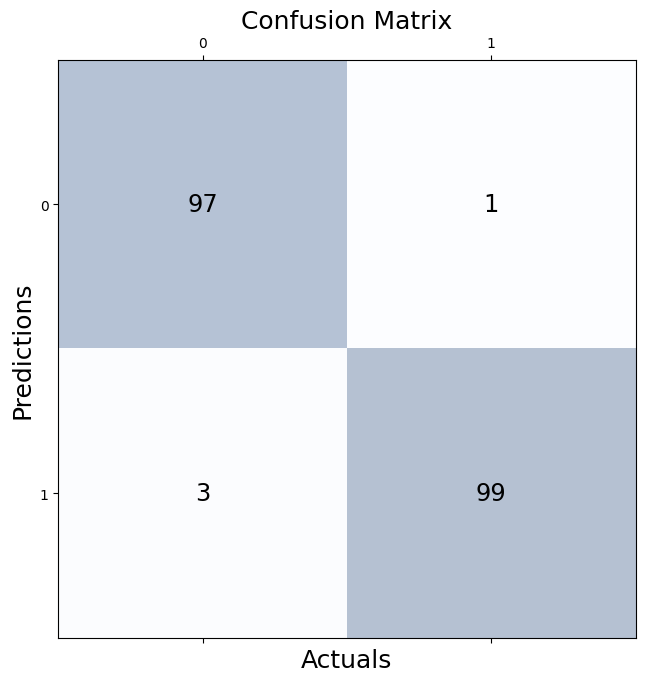

In [59]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(nwt_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(nwt_cf_matrix)):
    for j in range(len(nwt_cf_matrix[i])):
        ax.text(x=j, y=i,s=nwt_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/nwt_confusion_matrix.png')

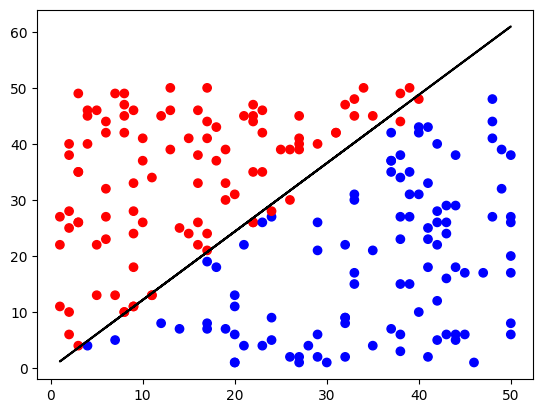

In [60]:
nwt_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], nwt_trained_weights).flatten()
nwt_plot_y = []
for i in range(len(nwt_vals)):
    nwt_plot_y.append(-(nwt_trained_weights[0] + (nwt_trained_weights[1] * data_x.iloc[i, 0])) / nwt_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], nwt_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/nwt_data_dist_db.png')

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:96: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


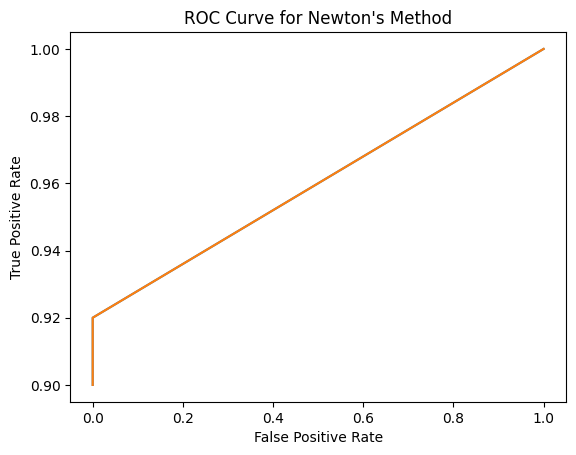

In [61]:
nwt_pred_prob = nwt.predict(data_x, prob=True)
nwt_tpr = []
nwt_fpr = []
for t in thresh:
    nwt_pred = [1 if i >= t else 0 for i in nwt_pred_prob]
    nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt_pred)
    tp = nwt_cf_info['tp']
    fp = nwt_cf_info['fp']
    tn = nwt_cf_info['tn']
    fn = nwt_cf_info['fn']
    nwt_tpr.append(tp/(tp+fn))
    nwt_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(nwt_fpr, nwt_tpr)
plt.plot(nwt_fpr, nwt_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Newton\'s Method')
plt.show()
fig.savefig('plots/nwt_roc.png')

## Using cross-validation Techniques

In [62]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [63]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.414
Iteration   200 | Cost:  24.917
Iteration   300 | Cost:  21.511
Iteration   400 | Cost:  19.437
Iteration   500 | Cost:  17.993
Iteration   600 | Cost:  16.907
Iteration   700 | Cost:  16.049
Iteration   800 | Cost:  15.347
Iteration   900 | Cost:  14.757
Iteration  1000 | Cost:  14.252
F1-score: 0.9836065573770492
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  42.688
Iteration   200 | Cost:  32.686
Iteration   300 | Cost:  28.132
Iteration   400 | Cost:  25.391
Iteration   500 | Cost:  23.502
Iteration   600 | Cost:  22.094
Iteration   700 | Cost:  20.989
Iteration   800 | Cost:  20.089
Iteration   900 | Cost:  19.336
Iteration  1000 | Cost:  18.694
F1-score: 1.0
----------------- lr : 0.003 -----------------


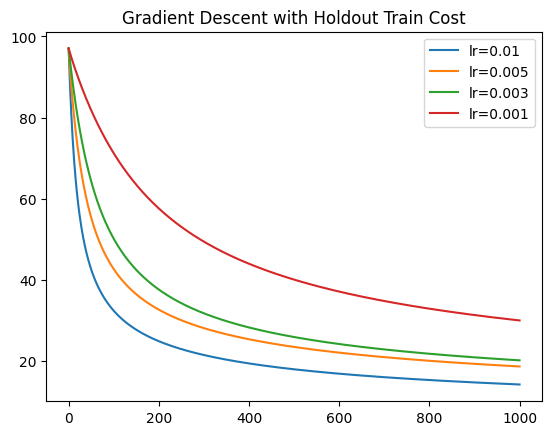

In [64]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [65]:
print(gd_hld_opt_model)

{'f1': 0.9259259259259259, 'lr': 0.003, 'w': array([[ 1.09487218],
       [-9.53410338],
       [ 6.62284709]])}


In [66]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

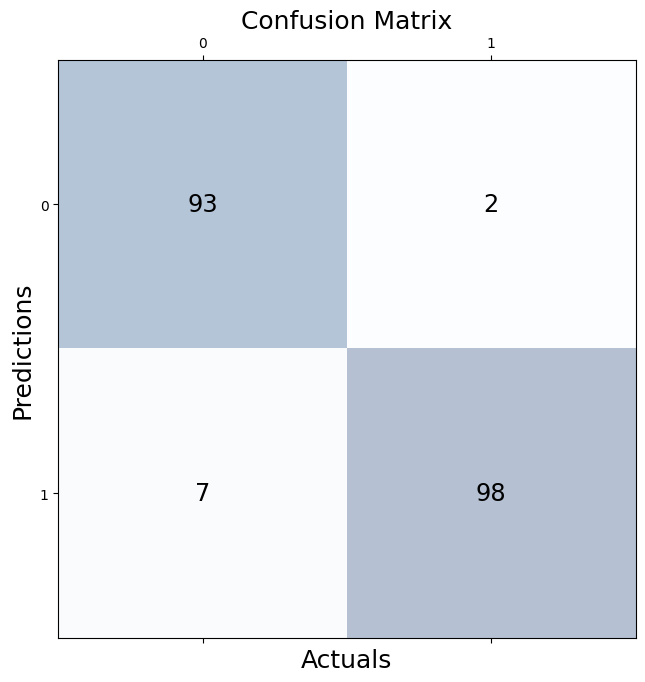

In [67]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

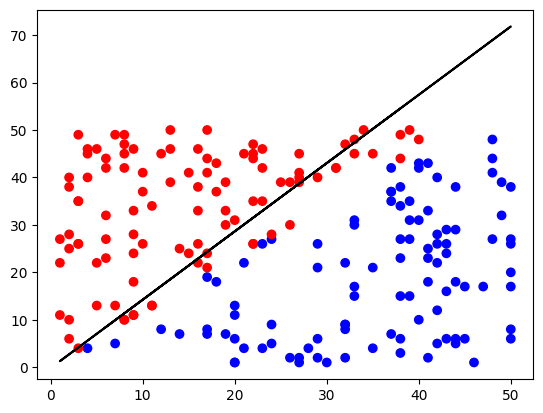

In [68]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

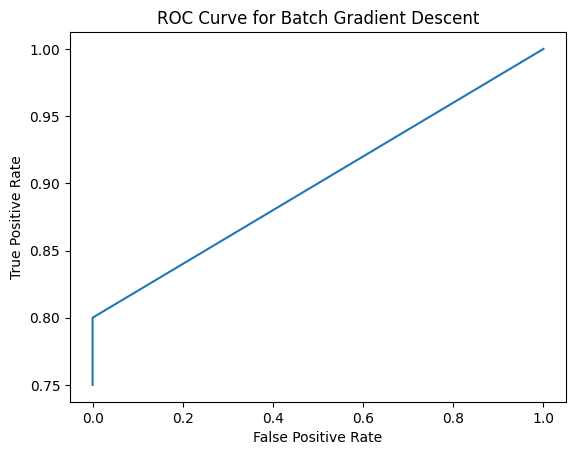

In [69]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [70]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  33.314
Iteration   200 | Cost:  25.453
Iteration   300 | Cost:  21.916
Iteration   400 | Cost:  19.785
Iteration   500 | Cost:  18.316
Iteration   600 | Cost:  17.223
Iteration   700 | Cost:  16.368
Iteration   800 | Cost:  15.675
Iteration   900 | Cost:  15.098
Iteration  1000 | Cost:  14.607
F1-score: 0.9824561403508771
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  42.027
Iteration   200 | Cost:  31.632
Iteration   300 | Cost:  26.935
Iteration   400 | Cost:  24.138
Iteration   500 | Cost:  22.232
Iteration   600 | Cost:  20.823
Iteration   700 | Cost:  19.725
Iteration   800 | Cost:  18.837
Iteration   900 | Cost:  18.097
Iteration  1000 | Cost:  17.467
F1-score: 0.967741935483871
----------------- lr : 

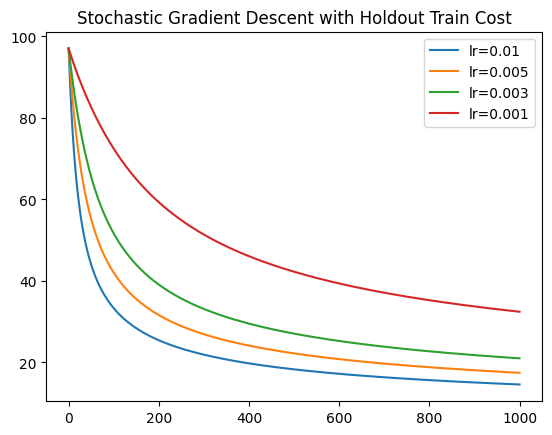

In [71]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [72]:
print(sgd_hld_opt_model)

{'f1': 0.9642857142857143, 'lr': 0.003, 'w': array([[ 0.52370021],
       [-9.01162513],
       [ 7.48461736]])}


In [73]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

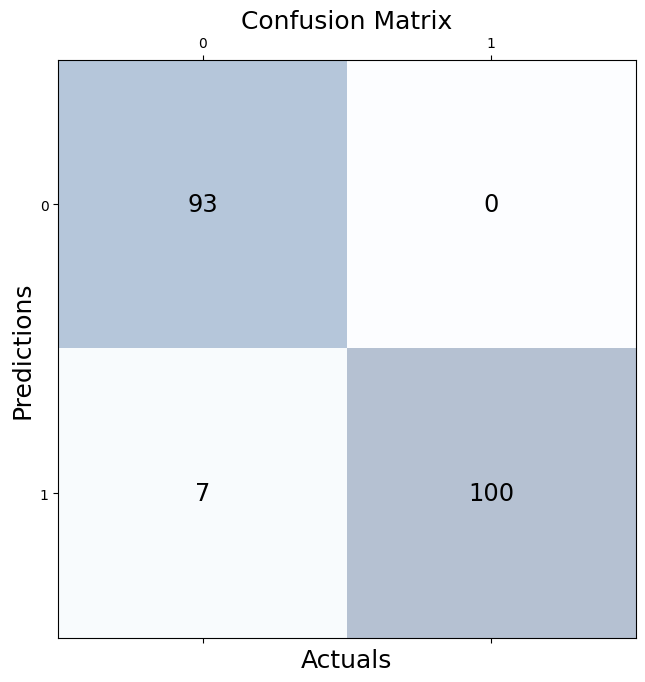

In [74]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

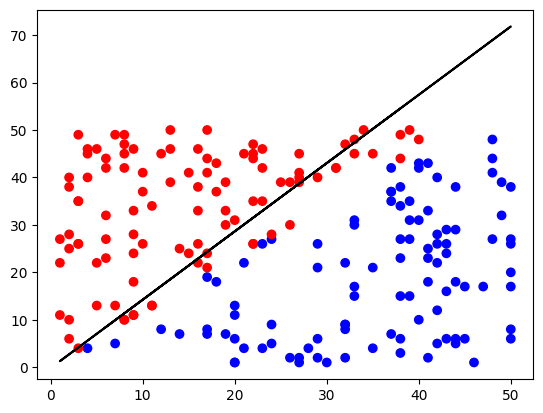

In [75]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

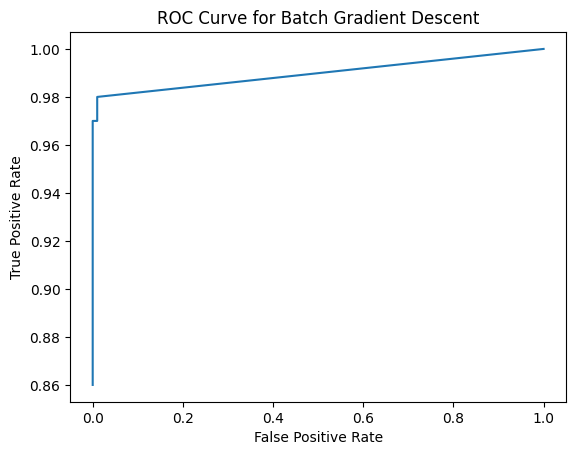

In [76]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [77]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.825
Iteration   200 | Cost:  24.015
Iteration   300 | Cost:  20.936
Iteration   400 | Cost:  19.054
Iteration   500 | Cost:  17.738
Iteration   600 | Cost:  16.744
Iteration   700 | Cost:  15.956
Iteration   800 | Cost:  15.309
Iteration   900 | Cost:  14.764
Iteration  1000 | Cost:  14.296
F1-score: 0.9850746268656716
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.858
Iteration   200 | Cost:  23.136
Iteration   300 | Cost:  19.634
Iteration   400 | Cost:  17.517
Iteration   500 | Cost:  16.054
Iteration   600 | Cost:  14.963
Iteration   700 | Cost:  14.107
Iteration   800 | Cost:  13.411
Iteration   900 | Cost:  12.830
Iteration  1000 | Cost:  12.336
F1-score: 0.9285714285714286
----------------- lr : 0.01 -

In [78]:
print(gd_montc_opt_model)

{'f1': 0.9565096179870218, 'lr': 0.005, 'w': array([[  0.45798898],
       [-11.05039751],
       [  9.25947195]])}


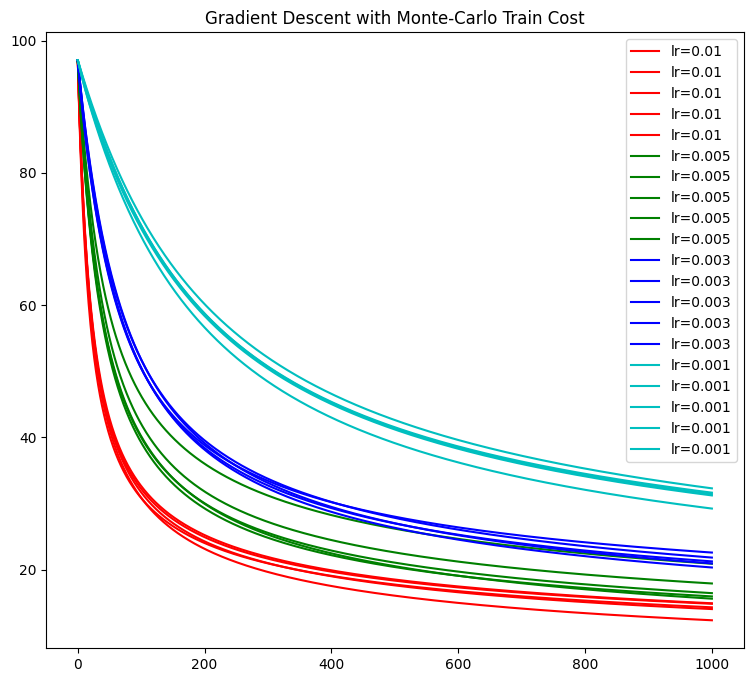

In [79]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [80]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.341
Iteration   200 | Cost:  24.757
Iteration   300 | Cost:  21.335
Iteration   400 | Cost:  19.262
Iteration   500 | Cost:  17.827
Iteration   600 | Cost:  16.753
Iteration   700 | Cost:  15.908
Iteration   800 | Cost:  15.220
Iteration   900 | Cost:  14.645
Iteration  1000 | Cost:  14.154
F1-score: 0.9508196721311475
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.149
Iteration   200 | Cost:  23.251
Iteration   300 | Cost:  19.749
Iteration   400 | Cost:  17.653
Iteration   500 | Cost:  16.212
Iteration   600 | Cost:  15.139
Iteration   700 | Cost:  14.298
Iteration   800 | Cost:  13.613
Iteration   900 | Cost:  13.042
Iteration  1000 | Cost:  12.554
F1-score: 0.958904109589041
----------------- lr

In [81]:
print(sgd_montc_opt_model)

{'f1': 0.9561237878365398, 'lr': 0.001, 'w': array([[ 0.41200781],
       [-5.5423839 ],
       [ 4.41825335]])}


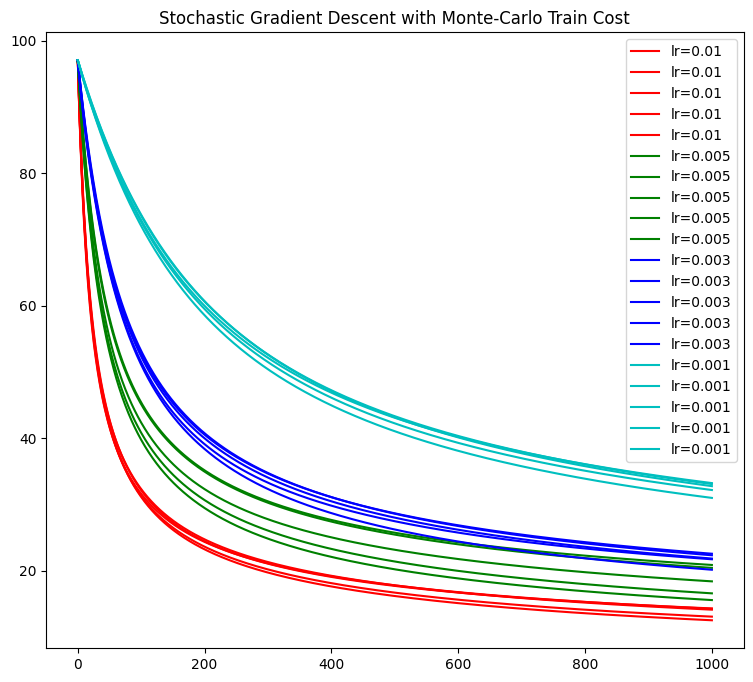

In [82]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [83]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.548
Iteration   200 | Cost:  27.560
Iteration   300 | Cost:  23.973
Iteration   400 | Cost:  21.801
Iteration   500 | Cost:  20.296
Iteration   600 | Cost:  19.168
Iteration   700 | Cost:  18.280
Iteration   800 | Cost:  17.554
Iteration   900 | Cost:  16.946
Iteration  1000 | Cost:  16.426
F1-score: 0.9714285714285714
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.417
Iteration   200 | Cost:  27.351
Iteration   300 | Cost:  23.720
Iteration   400 | Cost:  21.522
Iteration   500 | Cost:  19.999
Iteration   600 | Cost:  18.861
Iteration   700 | Cost:  17.965
Iteration   800 | Cost:  17.235
Iteration   900 | Cost:  16.624
Iteration  1000 | Cost:  16.102
F1-score: 0.9411764705882353
----------------- lr : 0.01 ----

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  16.235
F1-score: 0.972972972972973
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.157
Iteration   200 | Cost:  28.959
Iteration   300 | Cost:  25.278
Iteration   400 | Cost:  23.047
Iteration   500 | Cost:  21.497
Iteration   600 | Cost:  20.335
Iteration   700 | Cost:  19.418
Iteration   800 | Cost:  18.669
Iteration   900 | Cost:  18.041
Iteration  1000 | Cost:  17.504
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  34.625
Iteration   200 | Cost:  27.023
Iteration   300 | Cost:  23.653
Iteration   400 | Cost:  21.629
Iteration   500 | Cost:  20.233
Iteration   600 | Cost:  19.191
Iteration   700 | Cost:  18.373
Iteration   800 | Cost:  17.707
Iteration   900 | Cost:  17.150
Iteration  1000 | Cost:  16.675
F1-score: 1.0
----------------- lr : 0.005 -----------

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  50.280
Iteration   200 | Cost:  38.697
Iteration   300 | Cost:  33.391
Iteration   400 | Cost:  30.172
Iteration   500 | Cost:  27.941
Iteration   600 | Cost:  26.270
Iteration   700 | Cost:  24.953
Iteration   800 | Cost:  23.878
Iteration   900 | Cost:  22.976
Iteration  1000 | Cost:  22.205
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  44.669
Iteration   200 | Cost:  33.746
Iteration   300 | Cost:  28.880
Iteration   400 | Cost:  25.974
Iteration   500 | Cost:  23.982
Iteration   600 | Cost:  22.500
Iteration   700 | Cost:  21.340
Iteration   800 | Cost:  20.395
Iteration   900 | Cost:  19.606
Iteration  1000 | Cost:  18.933
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.329
Iteration   200 | Cost:  35.250
Iteration   300 | C

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  58.220
Iteration   200 | Cost:  43.928
Iteration   300 | Cost:  37.230
Iteration   400 | Cost:  33.198
Iteration   500 | Cost:  30.439
Iteration   600 | Cost:  28.398
Iteration   700 | Cost:  26.808
Iteration   800 | Cost:  25.523
Iteration   900 | Cost:  24.455
Iteration  1000 | Cost:  23.549
F1-score: 0.9411764705882353
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.635
Iteration   200 | Cost:  43.022
Iteration   300 | Cost:  36.717
Iteration   400 | Cost:  32.929
Iteration   500 | Cost:  30.334
Iteration   600 | Cost:  28.412
Iteration   700 | Cost:  26.911
Iteration   800 | Cost:  25.695
Iteration   900 | Cost:  24.683
Iteration  1000 | Cost:  23.822
F1-score: 0.972972972972973
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.745
Iteration   200 | Cost:  41.931
Itera

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   200 | Cost:  43.223
Iteration   300 | Cost:  36.963
Iteration   400 | Cost:  33.220
Iteration   500 | Cost:  30.664
Iteration   600 | Cost:  28.774
Iteration   700 | Cost:  27.301
Iteration   800 | Cost:  26.108
Iteration   900 | Cost:  25.115
Iteration  1000 | Cost:  24.271
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  59.137
Iteration   200 | Cost:  45.437
Iteration   300 | Cost:  39.029
Iteration   400 | Cost:  35.177
Iteration   500 | Cost:  32.542
Iteration   600 | Cost:  30.594
Iteration   700 | Cost:  29.076
Iteration   800 | Cost:  27.849
Iteration   900 | Cost:  26.828
Iteration  1000 | Cost:  25.962
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.569
Iteration   200 | Cost:  65.151
Iteration   300 | Cost:  55.809
Iteration   400 | C

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   300 | Cost:  55.051
Iteration   400 | Cost:  48.702
Iteration   500 | Cost:  44.201
Iteration   600 | Cost:  40.820
Iteration   700 | Cost:  38.171
Iteration   800 | Cost:  36.028
Iteration   900 | Cost:  34.250
Iteration  1000 | Cost:  32.746
F1-score: 0.8571428571428571
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.787
Iteration   200 | Cost:  67.850
Iteration   300 | Cost:  58.553
Iteration   400 | Cost:  52.445
Iteration   500 | Cost:  48.091
Iteration   600 | Cost:  44.805
Iteration   700 | Cost:  42.219
Iteration   800 | Cost:  40.118
Iteration   900 | Cost:  38.370
Iteration  1000 | Cost:  36.886
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.590
Iteration   200 | Cost:  68.702
Iteration   300 | Cost:  59.341
Iteration   400 | Cost:  53.164
Iteration   500 | C

In [84]:
print(gd_kfold_opt_model)

{'f1': 0.9613852289308679, 'lr': 0.003, 'w': array([[ 0.66149219],
       [-9.64706157],
       [ 7.78136714]])}


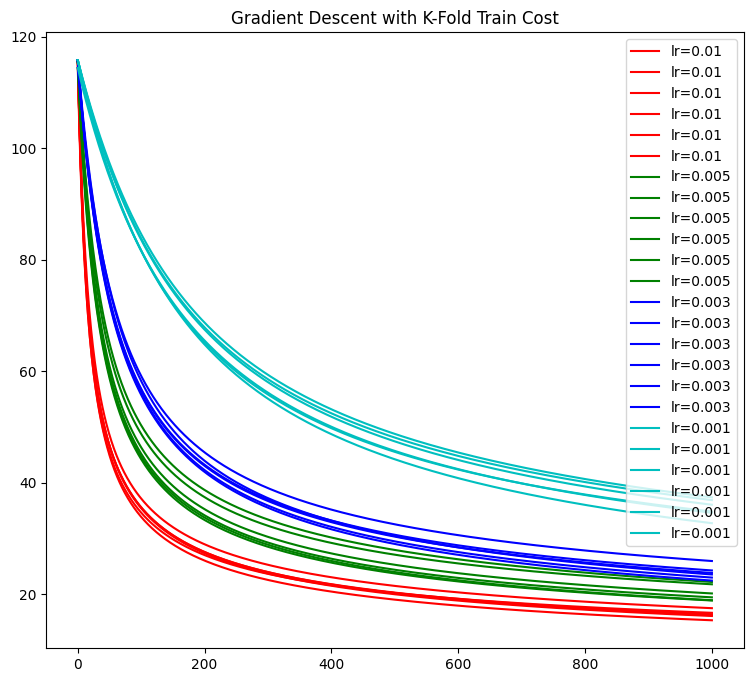

In [85]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [86]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.069
Iteration   200 | Cost:  27.981


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.319
Iteration   400 | Cost:  22.091
Iteration   500 | Cost:  20.542
Iteration   600 | Cost:  19.381
Iteration   700 | Cost:  18.465
Iteration   800 | Cost:  17.718
Iteration   900 | Cost:  17.093
Iteration  1000 | Cost:  16.558
F1-score: 0.9696969696969697
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.380


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  29.205
Iteration   300 | Cost:  25.530
Iteration   400 | Cost:  23.301
Iteration   500 | Cost:  21.754
Iteration   600 | Cost:  20.593
Iteration   700 | Cost:  19.678
Iteration   800 | Cost:  18.930
Iteration   900 | Cost:  18.303
Iteration  1000 | Cost:  17.766
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  34.717
Iteration   200 | Cost:  26.773
Iteration   300 | Cost:  23.219
Iteration   400 | Cost:  21.068
Iteration   500 | Cost:  19.576
Iteration   600 | Cost:  18.456
Iteration   700 | Cost:  17.573
Iteration   800 | Cost:  16.852
Iteration   900 | Cost:  16.247
Iteration  1000 | Cost:  15.729
F1-score: 0.9189189189189189
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  33.898
Iteration   200 | Cost:  25.706


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  22.087
Iteration   400 | Cost:  19.921
Iteration   500 | Cost:  18.433
Iteration   600 | Cost:  17.327
Iteration   700 | Cost:  16.461
Iteration   800 | Cost:  15.758
Iteration   900 | Cost:  15.172
Iteration  1000 | Cost:  14.674
F1-score: 0.9500000000000001
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.140


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.921
Iteration   300 | Cost:  24.258
Iteration   400 | Cost:  22.046
Iteration   500 | Cost:  20.515
Iteration   600 | Cost:  19.369
Iteration   700 | Cost:  18.466
Iteration   800 | Cost:  17.728
Iteration   900 | Cost:  17.111
Iteration  1000 | Cost:  16.582
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  34.793
Iteration   200 | Cost:  27.370
Iteration   300 | Cost:  24.064
Iteration   400 | Cost:  22.064
Iteration   500 | Cost:  20.674
Iteration   600 | Cost:  19.630
Iteration   700 | Cost:  18.804
Iteration   800 | Cost:  18.128
Iteration   900 | Cost:  17.559
Iteration  1000 | Cost:  17.070
F1-score: 0.975609756097561
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  45.989
Iteration   200 | Cost:  34.680


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  29.676
Iteration   400 | Cost:  26.713
Iteration   500 | Cost:  24.698
Iteration   600 | Cost:  23.210
Iteration   700 | Cost:  22.050
Iteration   800 | Cost:  21.113
Iteration   900 | Cost:  20.333
Iteration  1000 | Cost:  19.670
F1-score: 0.975609756097561
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  48.264


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  37.293
Iteration   300 | Cost:  32.378
Iteration   400 | Cost:  29.431
Iteration   500 | Cost:  27.403
Iteration   600 | Cost:  25.890
Iteration   700 | Cost:  24.701
Iteration   800 | Cost:  23.731
Iteration   900 | Cost:  22.919
Iteration  1000 | Cost:  22.224
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  46.007
Iteration   200 | Cost:  34.908
Iteration   300 | Cost:  29.933
Iteration   400 | Cost:  26.958
Iteration   500 | Cost:  24.921
Iteration   600 | Cost:  23.410
Iteration   700 | Cost:  22.229
Iteration   800 | Cost:  21.271
Iteration   900 | Cost:  20.473
Iteration  1000 | Cost:  19.793
F1-score: 0.9743589743589743
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  44.136
Iteration   200 | Cost:  32.862


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  27.811
Iteration   400 | Cost:  24.787
Iteration   500 | Cost:  22.710
Iteration   600 | Cost:  21.166
Iteration   700 | Cost:  19.955
Iteration   800 | Cost:  18.971
Iteration   900 | Cost:  18.150
Iteration  1000 | Cost:  17.449
F1-score: 0.8571428571428571
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.939


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  36.027
Iteration   300 | Cost:  31.104
Iteration   400 | Cost:  28.143
Iteration   500 | Cost:  26.103
Iteration   600 | Cost:  24.583
Iteration   700 | Cost:  23.391
Iteration   800 | Cost:  22.421
Iteration   900 | Cost:  21.611
Iteration  1000 | Cost:  20.920
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  48.554
Iteration   200 | Cost:  37.004
Iteration   300 | Cost:  31.805
Iteration   400 | Cost:  28.698
Iteration   500 | Cost:  26.570
Iteration   600 | Cost:  24.990
Iteration   700 | Cost:  23.755
Iteration   800 | Cost:  22.752
Iteration   900 | Cost:  21.915
Iteration  1000 | Cost:  21.201
F1-score: 0.9714285714285714
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.400
Iteration   200 | Cost:  44.293


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  37.682
Iteration   400 | Cost:  33.695
Iteration   500 | Cost:  30.961
Iteration   600 | Cost:  28.937
Iteration   700 | Cost:  27.359
Iteration   800 | Cost:  26.082
Iteration   900 | Cost:  25.021
Iteration  1000 | Cost:  24.121
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.252


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  43.392
Iteration   300 | Cost:  36.965
Iteration   400 | Cost:  33.114
Iteration   500 | Cost:  30.484
Iteration   600 | Cost:  28.540
Iteration   700 | Cost:  27.025
Iteration   800 | Cost:  25.799
Iteration   900 | Cost:  24.779
Iteration  1000 | Cost:  23.912
F1-score: 0.9523809523809523
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  59.225
Iteration   200 | Cost:  45.251
Iteration   300 | Cost:  38.685
Iteration   400 | Cost:  34.719
Iteration   500 | Cost:  31.994
Iteration   600 | Cost:  29.970
Iteration   700 | Cost:  28.388
Iteration   800 | Cost:  27.104
Iteration   900 | Cost:  26.034
Iteration  1000 | Cost:  25.123
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  54.651
Iteration   200 | Cost:  40.957


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  34.705
Iteration   400 | Cost:  30.994
Iteration   500 | Cost:  28.478
Iteration   600 | Cost:  26.631
Iteration   700 | Cost:  25.201
Iteration   800 | Cost:  24.051
Iteration   900 | Cost:  23.100
Iteration  1000 | Cost:  22.296
F1-score: 0.9714285714285714
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.907


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  42.341
Iteration   300 | Cost:  36.113
Iteration   400 | Cost:  32.396
Iteration   500 | Cost:  29.864
Iteration   600 | Cost:  27.995
Iteration   700 | Cost:  26.542
Iteration   800 | Cost:  25.369
Iteration   900 | Cost:  24.394
Iteration  1000 | Cost:  23.567
F1-score: 0.9285714285714286
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  57.755
Iteration   200 | Cost:  43.958
Iteration   300 | Cost:  37.517
Iteration   400 | Cost:  33.645
Iteration   500 | Cost:  30.995
Iteration   600 | Cost:  29.034
Iteration   700 | Cost:  27.506
Iteration   800 | Cost:  26.269
Iteration   900 | Cost:  25.241
Iteration  1000 | Cost:  24.367
F1-score: 0.9743589743589743
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.638
Iteration   200 | Cost:  66.355


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  56.934
Iteration   400 | Cost:  50.776
Iteration   500 | Cost:  46.402
Iteration   600 | Cost:  43.111
Iteration   700 | Cost:  40.528
Iteration   800 | Cost:  38.436
Iteration   900 | Cost:  36.699
Iteration  1000 | Cost:  35.229
F1-score: 0.9375
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  80.679


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  63.804
Iteration   300 | Cost:  54.153
Iteration   400 | Cost:  47.891
Iteration   500 | Cost:  43.467
Iteration   600 | Cost:  40.148
Iteration   700 | Cost:  37.550
Iteration   800 | Cost:  35.449
Iteration   900 | Cost:  33.706
Iteration  1000 | Cost:  32.231
F1-score: 0.8666666666666666
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  84.831
Iteration   200 | Cost:  68.795
Iteration   300 | Cost:  59.243
Iteration   400 | Cost:  52.907
Iteration   500 | Cost:  48.371
Iteration   600 | Cost:  44.940
Iteration   700 | Cost:  42.239
Iteration   800 | Cost:  40.046
Iteration   900 | Cost:  38.221
Iteration  1000 | Cost:  36.673
F1-score: 0.972972972972973
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.901
Iteration   200 | Cost:  67.865


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  58.479
Iteration   400 | Cost:  52.313
Iteration   500 | Cost:  47.924
Iteration   600 | Cost:  44.617
Iteration   700 | Cost:  42.019
Iteration   800 | Cost:  39.914
Iteration   900 | Cost:  38.164
Iteration  1000 | Cost:  36.681
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.531


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  67.563
Iteration   300 | Cost:  58.289
Iteration   400 | Cost:  52.216
Iteration   500 | Cost:  47.896
Iteration   600 | Cost:  44.639
Iteration   700 | Cost:  42.079
Iteration   800 | Cost:  40.000
Iteration   900 | Cost:  38.270
Iteration  1000 | Cost:  36.800
F1-score: 0.9696969696969697
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  81.293
Iteration   200 | Cost:  65.232
Iteration   300 | Cost:  56.002
Iteration   400 | Cost:  50.001
Iteration   500 | Cost:  45.755
Iteration   600 | Cost:  42.570
Iteration   700 | Cost:  40.075
Iteration   800 | Cost:  38.056
Iteration   900 | Cost:  36.382
Iteration  1000 | Cost:  34.965
F1-score: 1.0


In [87]:
print(sgd_kfold_opt_model)

{'f1': 0.9578061015561016, 'lr': 0.001, 'w': array([[ 0.32621849],
       [-6.05620818],
       [ 4.82382301]])}


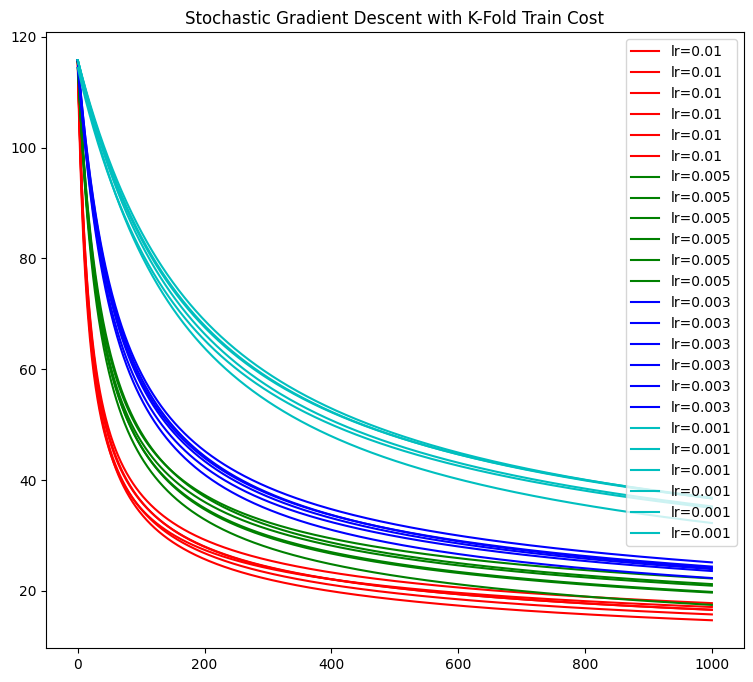

In [88]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [89]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  35.563
Iteration   200 | Cost:  27.590
Iteration   300 | Cost:  23.994
Iteration   400 | Cost:  21.812
Iteration   500 | Cost:  20.297
Iteration   600 | Cost:  19.163
Iteration   700 | Cost:  18.269
Iteration   800 | Cost:  17.540
Iteration   900 | Cost:  16.929
Iteration  1000 | Cost:  16.408
F1 Score:  0.9743589743589743


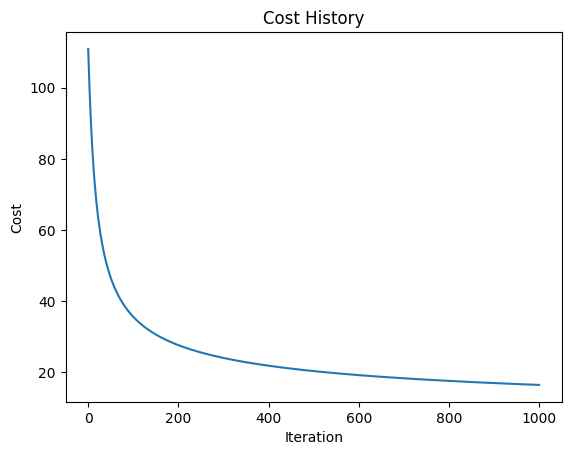

In [90]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [91]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  0.94318591]
 [-15.30512356]
 [ 11.93454465]]


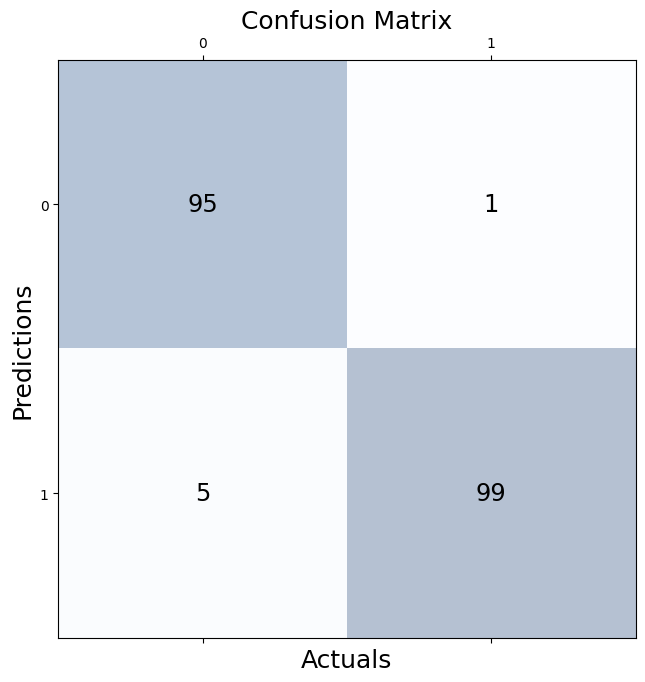

In [92]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

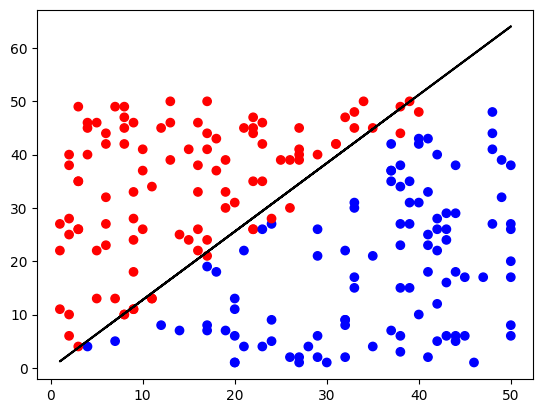

In [93]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

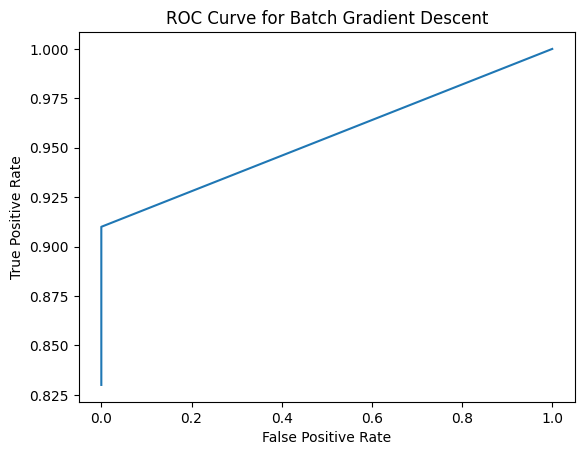

In [94]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [95]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGD=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  35.669
Iteration   200 | Cost:  27.639
Iteration   300 | Cost:  24.024
Iteration   400 | Cost:  21.833
Iteration   500 | Cost:  20.314
Iteration   600 | Cost:  19.176
Iteration   700 | Cost:  18.280
Iteration   800 | Cost:  17.549
Iteration   900 | Cost:  16.937
Iteration  1000 | Cost:  16.415
F1 Score:  0.9743589743589743


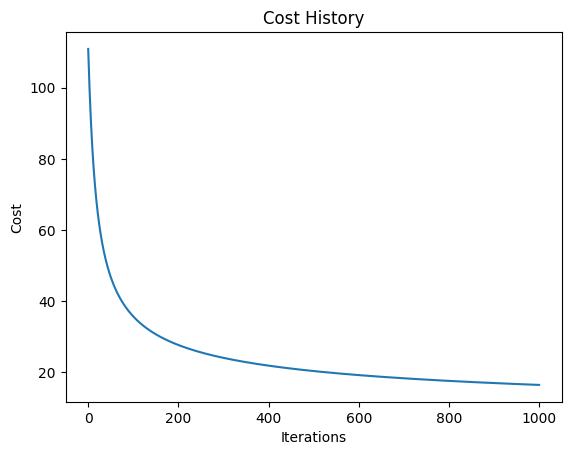

In [96]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [97]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  0.93079206]
 [-15.30196184]
 [ 11.92512049]]


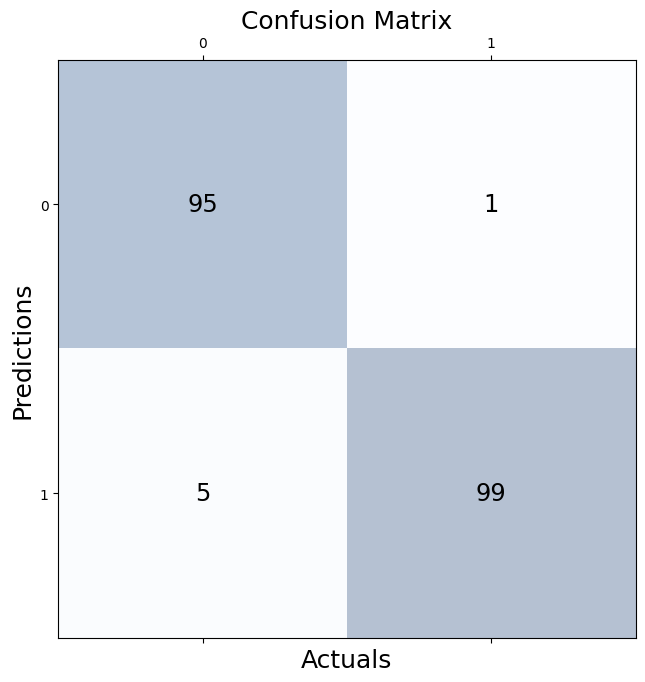

In [98]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

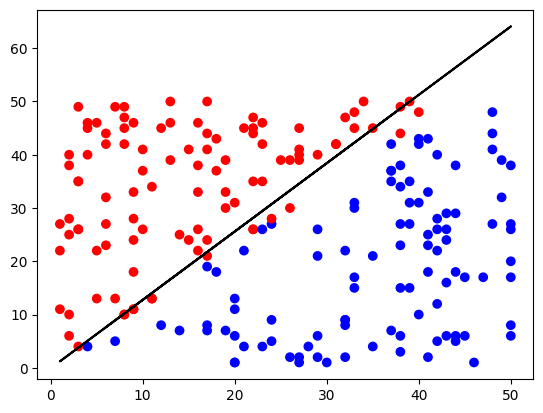

In [99]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

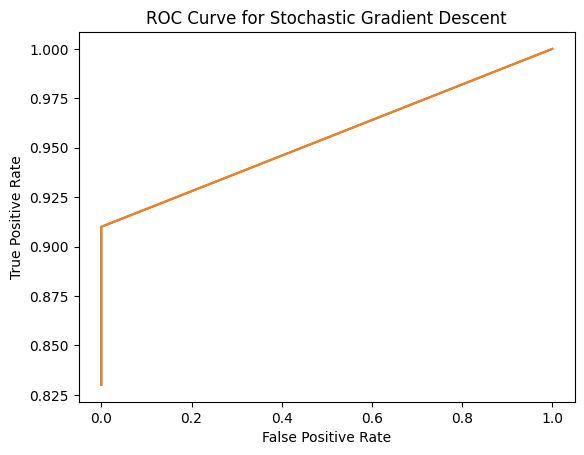

In [100]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')